In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [9]:

darkrate_df = pd.read_csv('PMT7_DR_polya_peak_positions.csv')

darkrate_df = darkrate_df[darkrate_df['polya_peak_pC'] > 0].reset_index(drop=True)

print('DARKRATE')
print(darkrate_df)

DARKRATE
    voltage  polya_peak_pC  polya_peak_error_pC
0      1750       1.490761             0.000622
1      1750       1.438780             0.000593
2      1750       1.442115             0.000586
3      1750       1.536344             0.000644
4      1750       1.473483             0.000608
5      1750       1.623898             0.000715
6      1800       1.245889             0.000084
7      1800       1.197377             0.000088
8      1800       1.209972             0.000087
9      1800       1.216644             0.000085
10     1800       1.228124             0.000086
11     1800       1.205578             0.000086
12     1850       1.388043             0.000183
13     1850       1.383299             0.000187
14     1850       1.380763             0.000183
15     1850       1.389800             0.000188
16     1850       1.783966             0.000391
17     1850       1.392513             0.000184
18     1900       1.739096             0.000416
19     1900       1.764209     

In [10]:
#add gain columns to the data frames

def add_gain_columns(df):
    df=df.copy()
    df['gain'] = (df['polya_peak_pC']*(1e-12)/(1.6e-19))
    df['gain_error'] = (df['polya_peak_error_pC']*(1e-12)/(1.6e-19))
    return df

darkrate_df = add_gain_columns(darkrate_df)

In [11]:
#find mean gain for each voltage in case of multiple trials

def average_gain_per_voltage(df):
    grouped = df.groupby('voltage')
    mean_gain = grouped['gain'].mean()
    mean_gain_err = grouped['gain_error'].apply(lambda errs: np.sqrt(np.sum(errs**2)) / len(errs)
    )
    
    out = pd.DataFrame({'voltage': mean_gain.index,
        'gain': mean_gain.values,
        'gain_error': mean_gain_err.values})
    
    return out.sort_values('voltage')

darkrate_avg_gain = average_gain_per_voltage(darkrate_df)
print(darkrate_avg_gain)

   voltage          gain     gain_error
0     1750  9.380604e+06    1605.912496
1     1800  7.607900e+06     219.919804
2     1850  9.081650e+06     593.139191
3     1900  1.101687e+07    1145.281294
4     1950  1.564450e+07    2816.523448
5     2000  2.089373e+07  461565.725958


In [12]:
#gain model and fitting
def gain_model(V, A, B):
    return A * V**(14 * B)

def fit_gain_curve(voltage, gain, gain_err, ignore_voltage=1750):
    mask = np.ones_like(voltage, dtype=bool)

    if ignore_voltage is not None:
        mask &= voltage != ignore_voltage
    
    
    p0 = [5e-20, 0.7] #initial guesses
    bounds = (
        [1e-25, 0.2],   # lower bounds: A, B
        [1e-18, 0.9]    # upper bounds: A, B
    )
    popt, pcov = curve_fit(
        gain_model,
        voltage[mask],
        gain[mask],
        sigma=gain_err[mask],
        absolute_sigma=True,
        p0=p0,
        bounds=bounds,
        maxfev=10000
    )
    '''
    popt, pcov = curve_fit(
        gain_model,
        voltage,
        gain,
        sigma=gain_err,
        absolute_sigma=True,
        p0=p0,
        maxfev=10000
    )
    '''
    A_fit, B_fit = popt
    err_A, err_B = np.sqrt(np.diag(pcov))

    return A_fit, B_fit, err_A, err_B



A_dark, B_dark, errA_dark, errB_dark = fit_gain_curve(
    darkrate_avg_gain['voltage'].values,
    darkrate_avg_gain['gain'].values,
    darkrate_avg_gain['gain_error'].values,
)


V_plot = np.linspace(darkrate_avg_gain['voltage'].min(),darkrate_avg_gain['voltage'].max(),300)


In [13]:
#compute chi squareds

def chi_squared(y_data, y_model, y_err, n_params):
    chi2 = np.sum(((y_data-y_model)/y_err)**2)
    dof = len(y_data)-n_params
    chi2_reduced = chi2/dof
    return chi2, chi2_reduced

y_dark_model = gain_model(darkrate_avg_gain['voltage'].values,A_dark,B_dark)
chi2_dark, chi2_red_dark = chi_squared(
    darkrate_avg_gain['gain'].values,
    y_dark_model,
    darkrate_avg_gain['gain_error'].values,
    n_params=2
)

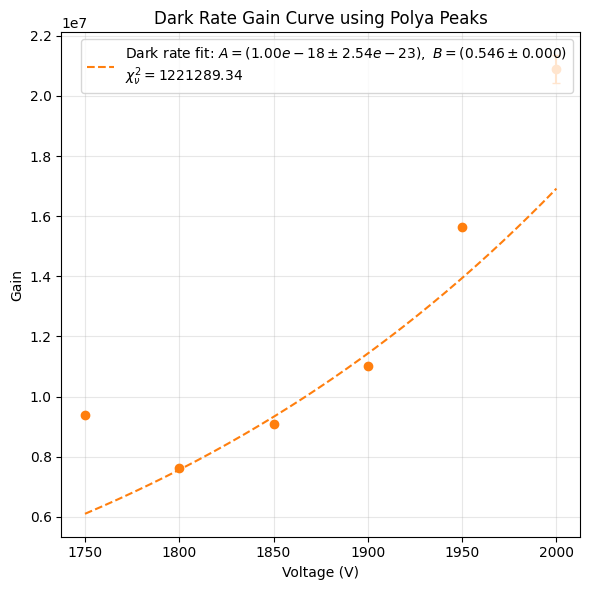

In [14]:

plt.figure(figsize=(6, 6))
plt.errorbar(darkrate_avg_gain['voltage'],darkrate_avg_gain['gain'],yerr=darkrate_avg_gain['gain_error'],fmt='o',color='tab:orange', capsize=3)
plt.plot(V_plot,gain_model(V_plot, A_dark, B_dark),'--',color='tab:orange',label=(
        rf'Dark rate fit: $A=({A_dark:.2e}\pm{errA_dark:.2e}),\ B=({B_dark:.3f}\pm{errB_dark:.3f})$'
        + f'\n$\\chi^2_\\nu={chi2_red_dark:.2f}$'
    ))
plt.xlabel('Voltage (V)')
plt.ylabel('Gain')
plt.title('Dark Rate Gain Curve using Polya Peaks')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.legend()
plt.show()